<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a undirected social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend highest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

# 以腳本執行之版本

In [3]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
import os.path
import shutil
# to install xgboost: pip3 install xgboost
import xgboost as xgb
import warnings
import networkx as nx
import pdb
from argparse import ArgumentParser, Namespace
import random
random.seed(25)


In [ ]:
def parse_args() -> Namespace:
    parser = ArgumentParser()
    parser.add_argument('--embedding', help='Which embedding to use.',default='GEMSEC')
    parser.add_argument('--dataset_path', help='Path of the dataset to be used.',default='./gemsec_facebook_dataset/facebook_clean_data/tvshow_edges.csv')

#     args = parser.parse_args(args=['--trainer-state', './bert_base_chinese/qa/trainer_state.json'])
    
    args = parser.parse_args()
    
    return args


args = parse_args()    


base_name=os.path.basename(args.dataset_path)

genre=base_name.split('.')[0].split('_')
genre.pop()
genre="_".join(genre)

print(args.embedding)
print(args.dataset_path)

In [4]:
#移除data 資料夾
if os.path.isdir('./data') and args.embedding=='GEMSEC':
    shutil.rmtree('./data')
elif os.path.isdir('./data'):
    shutil.rmtree('./data/fea_sample')
    

# 建立資料夾
os.makedirs('./data/after_eda', exist_ok=True)
os.makedirs('./data/fea_sample', exist_ok=True)


In [1]:
#建立results資料夾
os.makedirs(f"./results/{args.embedding}/{genre}/RandomForest", exist_ok=True)
os.makedirs(f"./results/{args.embedding}/{genre}/GBDT", exist_ok=True)

SyntaxError: EOL while scanning string literal (3388864724.py, line 3)

In [7]:
#reading graph
if not os.path.isfile('data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv(args.dataset_path)
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of duplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('data/after_eda/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
    g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)
    print(nx.info(g))
else:
    g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)
    print(nx.info(g))
max(g.nodes)

Empty DataFrame
Columns: [node_1, node_2]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17262 entries, 0 to 17261
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   node_1  17262 non-null  int64
 1   node_2  17262 non-null  int64
dtypes: int64(2)
memory usage: 269.8 KB
None
Number of diplicate entries:  0
saved the graph into file
Graph with 3892 nodes and 17262 edges


3891

In [5]:
# print(sorted(list(g.nodes))[:1000])

> Displaying a sub graph

Graph with 54 nodes and 50 edges


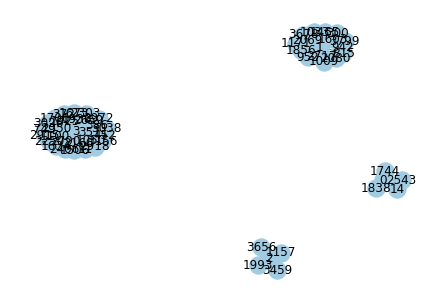

In [6]:
# if not os.path.isfile('train_woheader_sample.csv'):
#     pd.read_csv('./gemsec_facebook_dataset/facebook_clean_data/tvshow_edges.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
# subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)
# # https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

# pos=nx.spring_layout(subgraph)
# nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
# plt.savefig("graph_sample.pdf")
# print(nx.info(subgraph))

# 1. Exploratory Data Analysis

In [7]:
# # No of Unique persons 
# print("The number of unique persons",len(g.nodes()))

The number of unique persons 3892


## 1.1 No of neighbors for each person

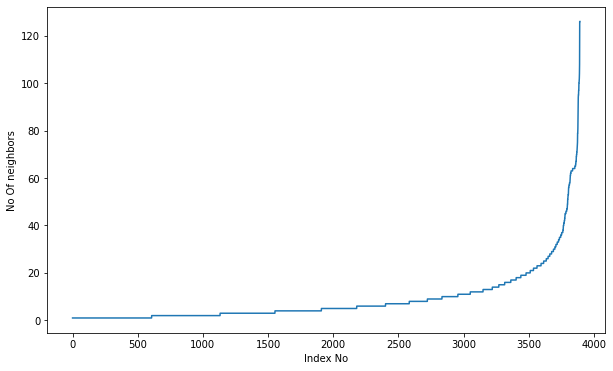

In [8]:
# degree_dist = list(dict(g.degree()).values())

# degree_dist.sort()

# plt.figure(figsize=(10,6))
# plt.plot(degree_dist)
# plt.xlabel('Index No')
# plt.ylabel('No Of neighbors')
# plt.show()

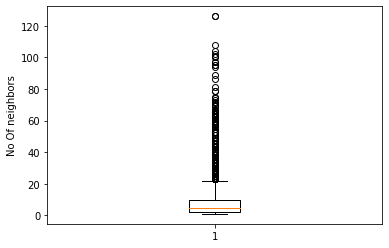

In [9]:
# plt.boxplot(degree_dist)
# plt.ylabel('No Of neighbors')
# plt.show()

In [10]:
# ### 90-100 percentile
# for i in range(0,11):
#     print(90+i,'percentile value is',np.percentile(degree_dist,90+i))

90 percentile value is 20.0
91 percentile value is 22.0
92 percentile value is 23.0
93 percentile value is 25.0
94 percentile value is 27.0
95 percentile value is 30.0
96 percentile value is 35.0
97 percentile value is 42.26999999999998
98 percentile value is 58.0
99 percentile value is 64.09000000000015
100 percentile value is 126.0


99% of data having followers of 40 only.

In [11]:
# ### 99-100 percentile
# for i in range(10,110,10):
#     print(99+(i/100),'percentile value is',np.percentile(degree_dist,99+(i/100)))

99.1 percentile value is 65.0
99.2 percentile value is 66.0
99.3 percentile value is 68.52599999999984
99.4 percentile value is 70.65400000000045
99.5 percentile value is 73.54500000000007
99.6 percentile value is 79.8720000000003
99.7 percentile value is 94.32699999999977
99.8 percentile value is 97.65399999999954
99.9 percentile value is 102.21800000000076
100.0 percentile value is 126.0


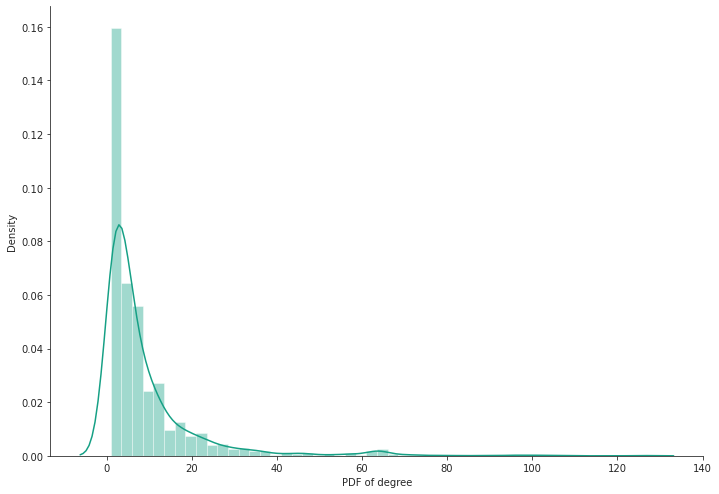

In [12]:
# %matplotlib inline
# sns.set_style('ticks')
# fig, ax = plt.subplots()
# fig.set_size_inches(11.7, 8.27)
# sns.distplot(degree_dist, color='#16A085')
# plt.xlabel('PDF of degree')
# sns.despine()
# #plt.show()

In [13]:
# print('No of persons having neighbor less than 10 are',np.sum(np.array(degree_dist)<10))

No of persons having neighbor less than 10 are 2834


In [14]:
# print('No of connected components',len(list(nx.connected_components(g))))
# count=0
# for i in list(nx.connected_components(g)):
#     if len(i)==2:
#         count+=1
# print('connected components with 2 nodes',count)

No of connected components 1
connected components with 2 nodes 0


# 2. Posing a problem as classification problem 

## 2.1 Generating some edges which are not present in graph for supervised learning  
Generated Bad links from graph which are not in graph and whose shortest path is greater than 2. 

In [8]:
###generating bad edges from given graph

if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(int(edge[0]), int(edge[1]))] = 1
        
    missing_edges = set([])
    g_edges_num=len(g.edges)
    g_nodes_num=len(g.nodes)
    while (len(missing_edges)<g_edges_num):
        a=random.randint(0,g_nodes_num-1)
        b=random.randint(0,g_nodes_num-1)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
#         print(len(missing_edges))
    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('data/after_eda/missing_edges_final.p','rb'))

Wall time: 10.8 s


In [9]:
len(missing_edges)

17262

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [10]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv(args.dataset_path)
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
#     del missing_edges
    pass

Number of nodes in the graph with edges 17262
Number of nodes in the graph without edges 17262
Number of nodes in the train data graph with edges 13809 = 13809
Number of nodes in the train data graph without edges 13809 = 13809
Number of nodes in the test data graph with edges 3453 = 3453
Number of nodes in the test data graph without edges 3453 = 3453


In [11]:
if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.Graph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Graph with 3754 nodes and 13809 edges
Graph with 2406 nodes and 3453 edges
no of people common in train and test --  2268
no of people present in train but not present in test --  1486
no of people present in test but not present in train --  138
 % of people not there in Train but exist in Test in total Test data are 5.7356608478802995 %


> we have a cold start problem here

In [12]:
#final train and test data sets
if (not os.path.isfile('data/after_eda/train_after_eda.csv')) and \
(not os.path.isfile('data/after_eda/test_after_eda.csv')) and \
(not os.path.isfile('data/train_y.csv')) and \
(not os.path.isfile('data/test_y.csv')) and \
(os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('data/after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('data/after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('data/after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('data/after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)
    
    print("Data points in train data",X_train.shape)
    print("Data points in test data",X_test.shape)
    print("Shape of traget variable in train",y_train.shape)
    print("Shape of traget variable in test", y_test.shape)

Number of nodes in the train data graph with edges 13809
Number of nodes in the train data graph without edges 13809
Number of nodes in the test data graph with edges 3453
Number of nodes in the test data graph without edges 3453


**Computed and store the data for featurization**

# 3. Features definition

In [14]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm

# 3.1 Load Embedding

In [15]:
embedding=pd.read_csv(f"./GEMSEC/output_PCA/{args.embedding}/embeddings/{genre}_embedding.csv")

Graph with 3754 nodes and 13809 edges


## 3.2 Define Embedding Function

In [ ]:
g_nodes=list(g.nodes)

In [ ]:
#To do: GEMSEC
#input:one node pair
#output:feature of that node pair

def get_embedding(a,b):
    embedding_=embedding.iloc[g_nodes.index(a)]
    embedding_.add(embedding.iloc[g_nodes.index(b)])
    return embedding_
        
        
        
    

# 4. Featurization

## 4.1 Reading data from both train and test

In [ ]:
df_final_train = pd.read_csv('data/after_eda/train_after_eda.csv', names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('data/train_y.csv', names=['indicator_link'])

print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

In [ ]:
df_final_test = pd.read_csv('data/after_eda/test_after_eda.csv', names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('data/test_y.csv', names=['indicator_link'])


print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

## 4.2 Adding one of the four multiple dimension features

__we will create these each of these features for both train and test data points__
<ol>
<li>GEMSEC</li>
<li>GEMSECWithRegularization</li>
<li>DeepWalk</li>
<li>DeepWalkWithRegularization</li>
</ol>

In [1]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    #mapping embedding to train and test data
    col=[str(i) for i in range(len(embedding.columns))]
    df_final_train[col] = \
    df_final_train.apply(lambda row:get_embedding(row['source_node'],row['destination_node']),axis=1)
  
    df_final_test[col] = \
    df_final_test.apply(lambda row:get_embedding(row['source_node'],row['destination_node']),axis=1)
    
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')   
    
    

SyntaxError: invalid syntax (1790932702.py, line 4)

**Store the data as final for machine learning models**

# RandomForest

In [ ]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')

In [ ]:
df_final_train.columns

In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [ ]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

# estimators = [10,50,100,250,450]
# train_scores = []
# test_scores = []
# for i in estimators:
#     clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=5, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0,
#             min_samples_leaf=52, min_samples_split=120,
#             min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
#     clf.fit(df_final_train,y_train)
#     train_sc = f1_score(y_train,clf.predict(df_final_train))
#     test_sc = f1_score(y_test,clf.predict(df_final_test))
#     test_scores.append(test_sc)
#     train_scores.append(train_sc)
#     print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
# plt.plot(estimators,train_scores,label='Train Score')
# plt.plot(estimators,test_scores,label='Test Score')
# plt.xlabel('Estimators')
# plt.ylabel('Score')
# plt.title('Estimators vs score at depth of 5')

In [ ]:
# depths = [3,9,11,15,20,35,50,70,130]
# train_scores = []
# test_scores = []
# for i in depths:
#     clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=i, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0,
#             min_samples_leaf=52, min_samples_split=120,
#             min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
#     clf.fit(df_final_train,y_train)
#     train_sc = f1_score(y_train,clf.predict(df_final_train))
#     test_sc = f1_score(y_test,clf.predict(df_final_test))
#     test_scores.append(test_sc)
#     train_scores.append(train_sc)
#     print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
# plt.plot(depths,train_scores,label='Train Score')
# plt.plot(depths,test_scores,label='Test Score')
# plt.xlabel('Depth')
# plt.ylabel('Score')
# plt.title('Depth vs score at depth of 5 at estimators = 115')
# plt.show()

In [ ]:
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
# print('mean train scores',rf_random.cv_results_['mean_train_score'])

In [ ]:
print(rf_random.best_estimator_)

In [ ]:
clf = rf_random.best_estimator_

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

In [ ]:
f = open("./results/RandomForest_f1_transposed.csv", "a")
#如果embedding 為GEMSEC 且 類型為artist,write csv header
if args.embedding=='GEMSEC' and genre=='artist':
    f.write('RandomForest_f1,GEMSEC,GEMSECWithRegularization,DeepWalk,DeepWalkWithRegularization,all other feature(with PCA),all other feature(without PCA)\n')
    

#如果embedding 為GEMSEC write row names
if args.embedding=='GEMSEC':
    f.write(genre+',')  
f.write(str(f1_score(y_test,y_test_pred))+',')
f.close()

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y,split):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.savefig(f"./results/{args.embedding}/{genre}/RandomForest/{split}_confusion_matrix.png")
    
    #plt.show()

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred,'Train')
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred,'Test')

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.savefig(f"./results/{args.embedding}/{genre}/RandomForest/roc_curve.png")
# plt.show()

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig(f"./results/{args.embedding}/{genre}/RandomForest/importance.png")
# plt.show()

# GBDT

In [ ]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('./data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
df_final_test = read_hdf('./data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')

In [ ]:
df_final_train

In [ ]:
df_final_train.columns

In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [ ]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

In [ ]:
param_dist = {"n_estimators":[10,50,100,250],
              "max_depth": [3,9,11,15,20,35,50,70,130]}

clf = GradientBoostingClassifier(random_state=25,verbose=1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])

In [ ]:
print(rf_random.best_estimator_)

In [ ]:
clf = rf_random.best_estimator_

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

In [ ]:
f = open("./results/GBDT_f1_transposed.csv", "a")
#如果embedding 為GEMSEC 且 類型為artist,write csv header
if args.embedding=='GEMSEC' and genre=='artist':
    f.write('GBDT_f1,GEMSEC,GEMSECWithRegularization,DeepWalk,DeepWalkWithRegularization,all other feature(with PCA),all other feature(without PCA)\n')
    
#如果embedding 為GEMSEC write row names
if args.embedding=='GEMSEC':
    f.write(genre+',')  
f.write(str(f1_score(y_test,y_test_pred))+',')
f.close()

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y, split):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    sns.set()
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.savefig(f"./results/{args.embedding}/{genre}/GBDT/{split}_confusion_matrix.png")
    
#     plt.show()

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred,'Train')
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred,'Test')

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.savefig(f"./results/{args.embedding}/{genre}/GBDT/roc_curve.png")
# plt.show()

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig(f"./results/{args.embedding}/{genre}/GBDT/importance.png")
# plt.show()